In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import shutil
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers.experimental import preprocessing
from sklearn.metrics import classification_report

In [3]:
train_dir = "birds/train/"
train_folder = os.listdir(train_dir)
print(f'Species in Train Set: {len(train_folder)}')

Species in Train Set: 525


In [4]:
file_paths = []
labels = []
size = 224,224
for folder in train_folder:
    for file in os.listdir(os.path.join(train_dir,folder)):
        if file.endswith("jpg"):
            file_paths.append(os.path.join(train_dir,folder,file))
            labels.append(folder)

In [5]:
data = {'Paths': file_paths, 'Labels': labels}
df = pd.DataFrame(data)

In [6]:
df.head()

,Paths,Labels
0,birds/train/TURKEY VULTURE/TURKEY VULTURE_orig...,TURKEY VULTURE
1,birds/train/TURKEY VULTURE/133.jpg,TURKEY VULTURE
2,birds/train/TURKEY VULTURE/test_4.jpg,TURKEY VULTURE
3,birds/train/TURKEY VULTURE/055.jpg,TURKEY VULTURE
4,birds/train/TURKEY VULTURE/018.jpg,TURKEY VULTURE


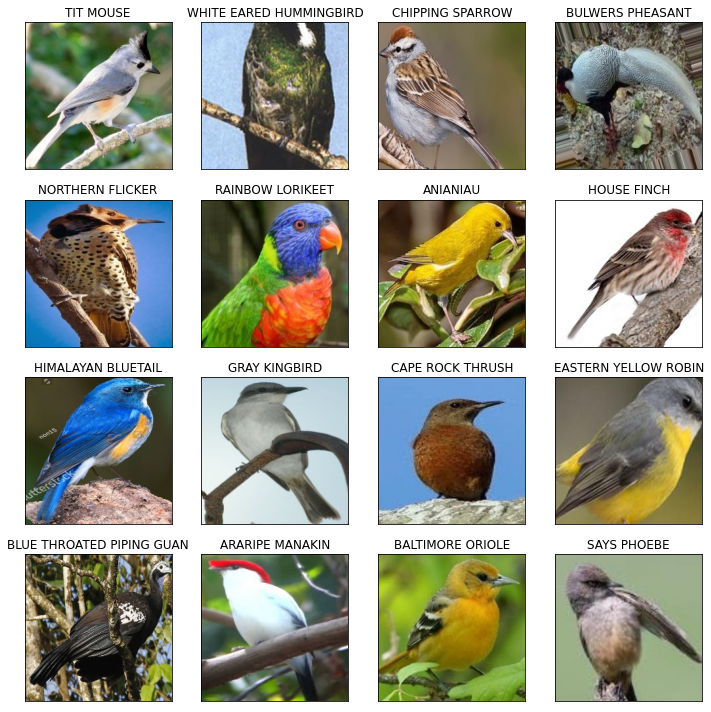

In [7]:
random_index = np.random.randint(0, len(df), 16)
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df.Paths[random_index[i]]))
    ax.set_title(df.Labels[random_index[i]])
plt.tight_layout()
plt.show()

In [8]:
train_df, test_df = train_test_split(df, test_size=0.2, shuffle=True, random_state=42)

In [9]:
train_generator = ImageDataGenerator(
    validation_split=0.2,
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input
)
test_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input
)

In [10]:
class_names = df['Labels'].unique() 
IMAGE_SIZE = (128, 128)
BATCH_SIZE = 32
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Paths',
    y_col='Labels',
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    class_names=class_names,
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Paths',
    y_col='Labels',
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    class_names=class_names,
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Paths',
    y_col='Labels',
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    class_names=class_names,
    batch_size=BATCH_SIZE,
    shuffle=False
)


Found 91728 validated image filenames belonging to 525 classes.
Found 22932 validated image filenames belonging to 525 classes.
Found 28665 validated image filenames belonging to 525 classes.


In [10]:
resnet_base=tf.keras.applications.resnet50.ResNet50(input_shape=(128,128,3),
                                                    include_top=False,
                                                    weights='imagenet',
                                                    pooling='avg')

2023-12-18 14:21:21.978613: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-18 14:21:22.011027: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-18 14:21:22.011198: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [11]:
resnet_base.trainable = False

In [12]:
num_classes = 525
model_resnet = tf.keras.models.Sequential([
    resnet_base,
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.45),
    tf.keras.layers.Dense(num_classes, activation='softmax'),
    
])
model_resnet.compile(optimizer=Adam(0.0001),
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])

model_resnet.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense (Dense)               (None, 1024)              2098176   
                                                                 
 batch_normalization (Batch  (None, 1024)              4096      
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 525)               538125    
                                                                 
Total params: 26228109 (100.05 MB)
Trainable params: 2638349 (10.06 MB)
Non-trainable params: 23589760 (89.99 MB)
________

In [13]:
train_steps = len(train_images)
valid_steps = len(val_images)

In [14]:
early_stop = EarlyStopping(monitor='val_loss',
                           patience=5,
                           restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)

In [15]:
history = model_resnet.fit(
        train_images,
        steps_per_epoch=train_steps,
        epochs=50,
        validation_data=val_images,
        validation_steps=valid_steps,
        callbacks=[early_stop,
              reduce_lr]
)

Epoch 1/50


2023-12-18 14:21:35.343636: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2023-12-18 14:21:35.498690: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-12-18 14:21:37.491602: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-12-18 14:21:41.572888: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.21GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-12-18 14:21:41.812662: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.21GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance 

2867/2867 [==============================] - ETA: 0s - loss: 2.7861 - accuracy: 0.4393

2023-12-18 14:37:35.362971: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.16GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-12-18 14:37:35.577151: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.16GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


2867/2867 [==============================] - 965s 332ms/step - loss: 2.7861 - accuracy: 0.4393 - val_loss: 1.1786 - val_accuracy: 0.7427 - lr: 1.0000e-04
Epoch 2/50
2867/2867 [==============================] - 931s 325ms/step - loss: 1.1304 - accuracy: 0.7286 - val_loss: 0.8290 - val_accuracy: 0.8022 - lr: 1.0000e-04
Epoch 3/50
2867/2867 [==============================] - 931s 325ms/step - loss: 0.7846 - accuracy: 0.8042 - val_loss: 0.7027 - val_accuracy: 0.8267 - lr: 1.0000e-04
Epoch 4/50
2867/2867 [==============================] - 931s 325ms/step - loss: 0.5954 - accuracy: 0.8476 - val_loss: 0.6368 - val_accuracy: 0.8382 - lr: 1.0000e-04
Epoch 5/50
2867/2867 [==============================] - 935s 326ms/step - loss: 0.4691 - accuracy: 0.8789 - val_loss: 0.5936 - val_accuracy: 0.8483 - lr: 1.0000e-04
Epoch 6/50
2867/2867 [==============================] - 946s 330ms/step - loss: 0.3827 - accuracy: 0.8993 - val_loss: 0.5705 - val_accuracy: 0.8537 - lr: 1.0000e-04
Epoch 7/50
2867/2867 

Training accuracy: 0.997613
Validation accuracy: 0.884223


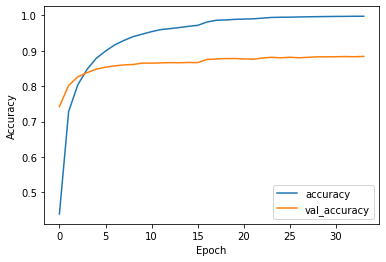

In [16]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

print('Training accuracy: %f' % history.history['accuracy'][-1])
print('Validation accuracy: %f' % history.history['val_accuracy'][-1])

Training loss: 0.015467
Validation loss: 0.506579


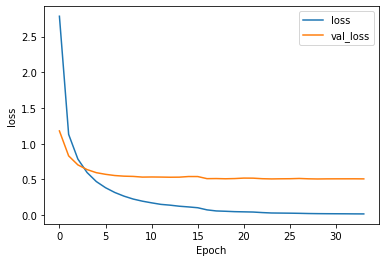

In [17]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.legend()

print('Training loss: %f' % history.history['loss'][-1])
print('Validation loss: %f' % history.history['val_loss'][-1])

In [19]:
scores = model_resnet.evaluate(test_images, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

895/896 [============================>.] - ETA: 0s - loss: 0.4982 - accuracy: 0.8852

2023-12-19 05:40:24.529723: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.18GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-12-19 05:40:24.693560: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.18GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


896/896 [==============================] - 341s 381ms/step - loss: 0.4982 - accuracy: 0.8852
Test loss: 0.4982055425643921
Test accuracy: 0.8852258920669556


In [20]:
pred = model_resnet.predict(test_images)
pred = np.argmax(pred, axis=1)

896/896 [==============================] - 180s 199ms/step


In [21]:
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

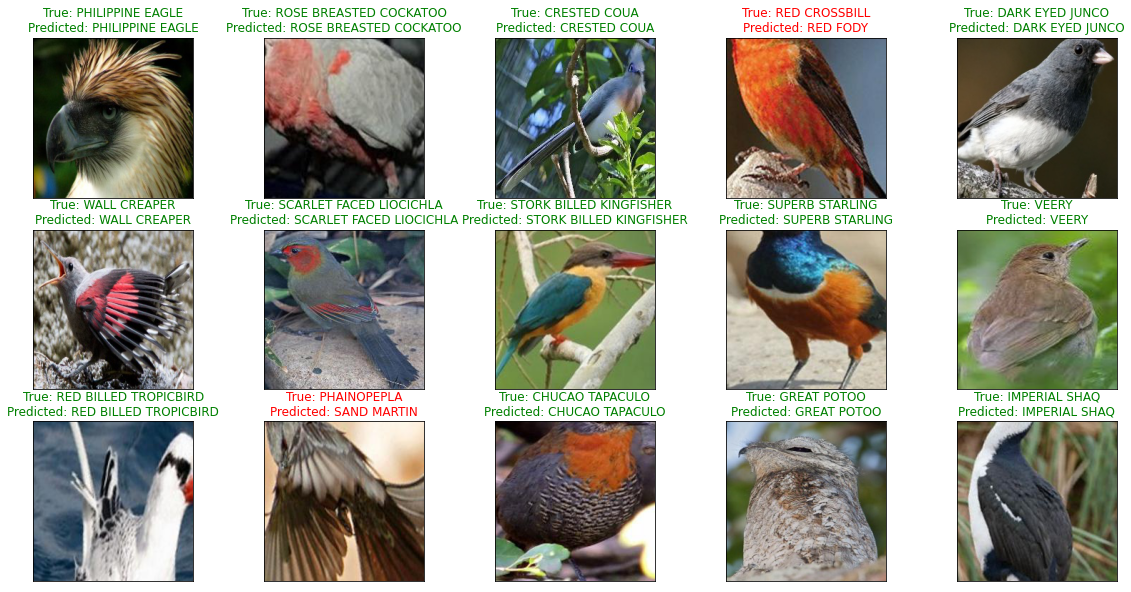

<Figure size 432x288 with 0 Axes>

In [24]:
random_index = np.random.randint(0, len(test_df) - 1, 15)
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(20, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Paths.iloc[random_index[i]]))
    if test_df.Labels.iloc[random_index[i]] == pred[random_index[i]]:
        color = "green"
    else:
        color = "red"
    ax.set_title(f"True: {test_df.Labels.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}", color=color)
plt.show()
plt.tight_layout()

In [23]:
from sklearn.metrics import classification_report
y_test = list(test_df.Labels)
print(classification_report(y_test, pred))

                               precision    recall  f1-score   support

              ABBOTTS BABBLER       0.49      0.74      0.59        35
                ABBOTTS BOOBY       0.67      0.82      0.74        51
   ABYSSINIAN GROUND HORNBILL       0.92      0.82      0.87        56
        AFRICAN CROWNED CRANE       0.98      0.97      0.97        58
       AFRICAN EMERALD CUCKOO       0.75      0.75      0.75        53
            AFRICAN FIREFINCH       0.88      0.84      0.86        51
       AFRICAN OYSTER CATCHER       0.96      0.92      0.94        59
        AFRICAN PIED HORNBILL       0.83      0.72      0.77        60
          AFRICAN PYGMY GOOSE       0.98      0.94      0.96        62
                    ALBATROSS       0.81      0.90      0.85        48
               ALBERTS TOWHEE       0.84      0.94      0.88        49
         ALEXANDRINE PARAKEET       0.89      0.94      0.92        52
                ALPINE CHOUGH       0.88      0.89      0.89        66
     